In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.signal import hilbert, butter, filtfilt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import random

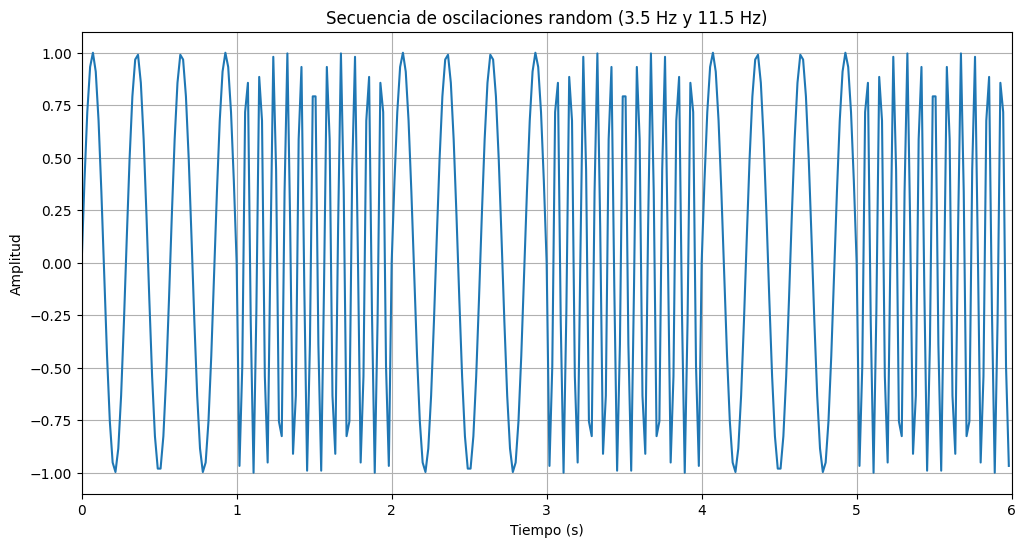

In [2]:
# Parámetros  
fs = 55            # Frecuencia de muestreo en Hz  
t_total = 6        # Duración total en segundos  
f1 = 3.5            # Frecuencia de la primera oscilación en Hz  
f2 = 11.5           # Frecuencia de la segunda oscilación en Hz  
duracion_segmento = 1  # Duración de cada segmento en segundos  
num_repeticiones = 6 # Número total de segmentos (3 de cada oscilacion) 

# vector de tiempo
t = np.arange(0, t_total, 1/fs) 

# Generamos las oscilaciones aleatorias   

amplitud = 1  # Amplitud aleatoria para la osc. 

# Inicializamos la secuencia  
secuencia = np.zeros_like(t)

# Llenar la secuencia con oscilaciones alternando  
for i in range(num_repeticiones):  
    if i % 2 == 0:  # Índices pares para la primera oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud  * np.sin(2 * np.pi * f1 * t[start:end])  
    else:  # Índices impares para la segunda oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud * np.sin(2 * np.pi * f2 * t[start:end])
# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t, secuencia)  
plt.title('Secuencia de oscilaciones random (3.5 Hz y 11.5 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Clásico

In [3]:
# Parámetros
num_input_channels = 1      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 10   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = t.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

sec = secuencia.reshape(1, len(secuencia))


# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        #(0.05 * input2res @ secuencia[i, np.newaxis]) +
        (0.05 * input2res @ sec[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS.shape)
analytic_signal = hilbert(RS)
amplitude_envelope = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS.shape)
print(amplitude_envelope.shape)

(10, 331)
(10, 331)
(10, 331)
(10, 331)


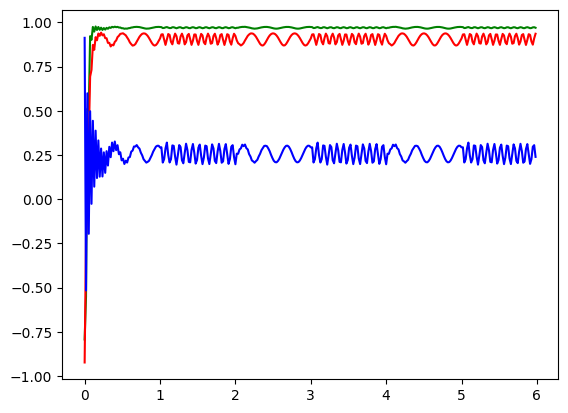

In [4]:
plt.plot(t, reservoir_states[0, 1:], color = 'green')
plt.plot(t, reservoir_states[1, 1:], color = 'red')
plt.plot(t, reservoir_states[2, 1:], color = 'blue')
plt.show()

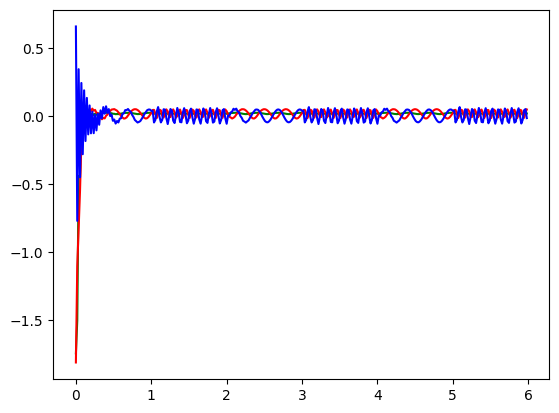

In [5]:
plt.plot(t, RS[0, 1:], color = 'green')
plt.plot(t, RS[1, 1:], color = 'red')
plt.plot(t, RS[2, 1:], color = 'blue')
plt.show()

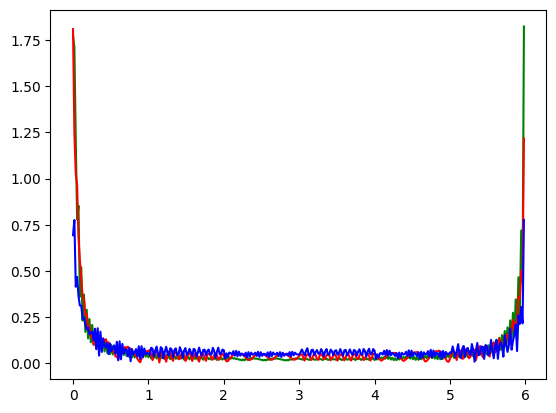

In [6]:
plt.plot(t, amplitude_envelope[0, 1:], color = 'green')
plt.plot(t, amplitude_envelope[1, 1:], color = 'red')
plt.plot(t, amplitude_envelope[2, 1:], color = 'blue')
plt.show()

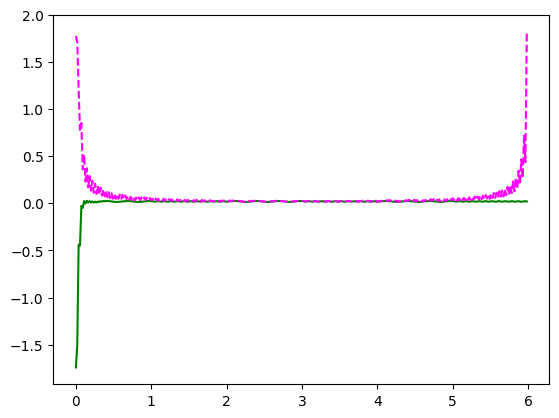

In [7]:
plt.plot(t, RS[0, 1:], color = 'green')
plt.plot(t, amplitude_envelope[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

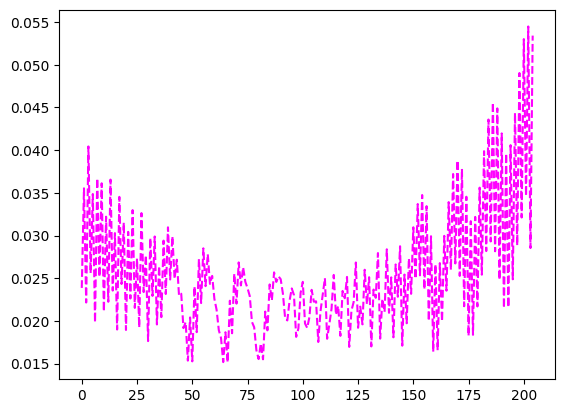

In [8]:
# Eliminamos los primeros 75 puntos para estabilizar el reservorio
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [9]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.02490381 0.03792659 0.06041272 0.05116499 0.04765574 0.05129309
  0.04906843 0.01912454 0.14646015 0.0392286 ]
 [0.02631121 0.03801302 0.04906873 0.05897124 0.10817271 0.05940414
  0.06321901 0.03010507 0.11702742 0.04849691]]
(206,)


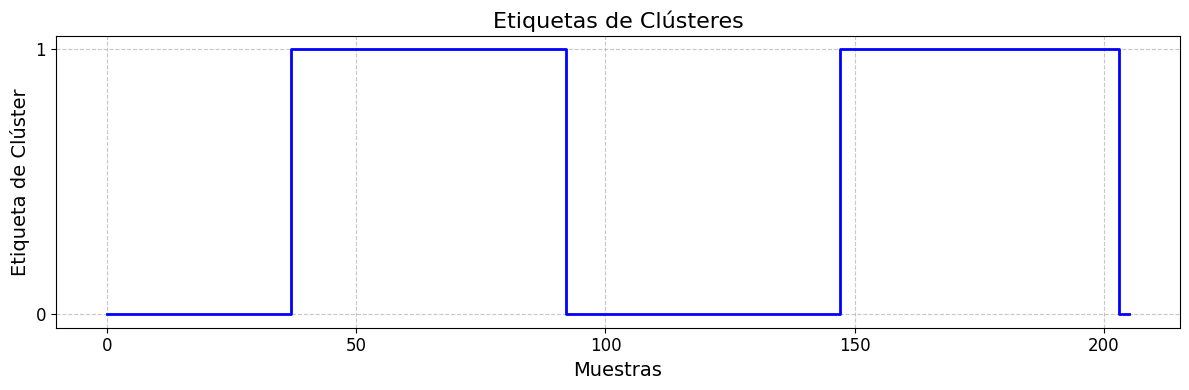

In [10]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Cuántico

In [11]:
# Number of qubits (size of quantum reservoir)
num_qubits = 10
# Depth of the reservoir circuit
num_layers = 1  

# Create a quantum device (simulator)
dev = qml.device("default.qubit", wires=num_qubits)

In [12]:
def apply_RX(theta, state):  
    """Aplica la compuerta RX al estado dado en la qubit correspondiente."""  
    RX_matrix = np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2)],  
                          [-1j * np.sin(theta / 2), np.cos(theta / 2)]])  
    # Numero total de qubits  
    dim = 2 ** num_qubits  
    
    # Crear una matriz identidad de dimensión total  
    full_matrix = np.eye(dim, dtype=complex)  
    
    # Insertar la matriz RX en la posición adecuada  
    for i in range(2 ** (num_qubits - 1)):  
        full_matrix[2*i, 2*i] = RX_matrix[0, 0]  
        full_matrix[2*i, 2*i + 1] = RX_matrix[0, 1]  
        full_matrix[2*i + 1, 2*i] = RX_matrix[1, 0]  
        full_matrix[2*i + 1, 2*i + 1] = RX_matrix[1, 1]  

    return np.dot(full_matrix, state) 

def apply_CNOT(state, control_index, target_index):  
    """Aplica la compuerta CNOT entre dos qubits en el estado dado."""  
    dim = 2 ** num_qubits  
    CNOT_matrix = np.eye(dim, dtype=complex)  
    # Crear la matriz CNOT  
    for i in range(dim):  
        binary = f"{i:0{num_qubits}b}"  
        control_qubit = int(binary[control_index])  # Estado del qubit de control  
        target_qubit = int(binary[target_index])     # Estado del qubit objetivo  

        # Si el qubit de control es 1, hacemos flip en el objetivo  
        if control_qubit == 1:  
            new_target_qubit = target_qubit ^ 1  # Flip  
            new_value = i & ~(1 << target_index) | (new_target_qubit << target_index)  
            CNOT_matrix[new_value, i] = 1  # Mover probabilidad de qubit viejo a nuevo  

    return np.dot(CNOT_matrix, state)  

def quantum_reservoir(reservoir_weights, num_qubits, initial_states):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""
    # Aplicar rotaciones y CNOTs    
    states = []
    for i in range(num_qubits):  
        # Rotación aleatoria en cada qubit  
        theta = reservoir_weights[i, i]
        state = apply_RX(theta, initial_states[i])  
        # Entrelazamiento con el siguiente qubit (circular)  
        target_qubit = (i + 1) % num_qubits  
        state = apply_CNOT(state, i, target_qubit) 
        states.append(state) 

    return states  

def compute_expectation_z(state):  
    """Calcula los valores de expectativa para cada qubit utilizando Z."""   
    dim = 2 ** num_qubits  # Dimensión total del espacio de Hilbert  

    # Iterar sobre cada qubit  
    for i in range(num_qubits):  
        # Crear la matriz Pauli-Z para el qubit i  
        Z_matrix = np.eye(dim, dtype=complex)  
        for j in range(dim):  
            binary = f"{j:0{num_qubits}b}"  
            # Si el qubit i es 1, cambia el signo  
            if binary[i] == '1':  
                Z_matrix[j, j] = -1  # Cambio de signo  

        # Calcular la expectativa  
        expectation_value = np.dot(state.conj().T, np.dot(Z_matrix, state)).real

    return expectation_value 

In [13]:
# Definir el Quantum Reservoir  
def quantum_reservoir(reservoir_weights):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            # Entrelazamiento con el siguiente qubit (circular)  
            control_qubit = i 
            target_qubit = (i + 1) % num_qubits  
            qml.CNOT(wires=[control_qubit, target_qubit])

In [14]:
# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights)
    
    # Measure expectation values (output features)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [15]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec = secuencia.reshape(1, len(secuencia))
input_series = sec
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps))
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[:, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output).squeeze()
    #outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {outputs[:, t0]}")

Step 0: [-0.00319991  0.45219846 -0.35544544 -0.29805399  0.34005812  0.23609386
 -0.03091648  0.02630993  0.61914241 -0.04690502]
Step 1: [-0.00694329 -0.07134294 -0.59067309 -0.34362599  0.37274836  0.16321111
 -0.0300393   0.0279033   0.61075021 -0.04587462]
Step 2: [-0.01026113  0.49534888 -0.635987   -0.35380699  0.37675657  0.18134266
 -0.02960601  0.02789053  0.60809969 -0.04547621]
Step 3: [-0.01256981 -0.14019717 -0.63619136 -0.35811913  0.3779887   0.17344228
 -0.02930244  0.02781423  0.60611213 -0.04521125]
Step 4: [-0.01351121  0.5366555  -0.63619822 -0.35946905  0.37837172  0.17503125
 -0.02920661  0.02778547  0.60547661 -0.04512919]
Step 5: [-0.01294844 -0.19056834 -0.63618219 -0.35818     0.37801571  0.17559413
 -0.02934185  0.02781529  0.60638609 -0.04524328]
Step 6: [-0.01096568  0.56812452 -0.63613887 -0.35425722  0.37698248  0.17811836
 -0.02967458  0.02789926  0.60855364 -0.04553497]
Step 7: [-0.00785821 -0.2143463  -0.63606977 -0.34773281  0.37541778  0.18127522
 -

In [16]:
print(outputs.shape)
print(t.shape)

(10, 330)
(330,)


(10, 330)


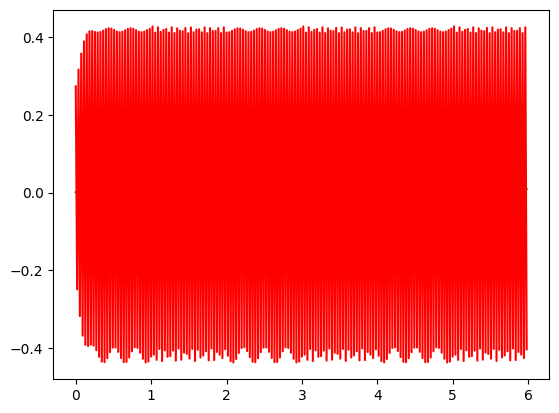

In [17]:
# Extracción de la envolvente superior usando Hilbert transform
RS_cuantico = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico.shape)

plt.plot(t, RS_cuantico[0, :], color = 'green')
plt.plot(t, RS_cuantico[1, :], color = 'red')
plt.show()

In [18]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 1  # Frecuencia baja del filtro
highcut = 12  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS_cuantico, lowcut, highcut, fs)

In [19]:
analytic_signal = hilbert(x_filtered)
amplitude_envelope = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope.shape)

(10, 330)
(10, 330)


C:\Users\Yolanda\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Yolanda\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


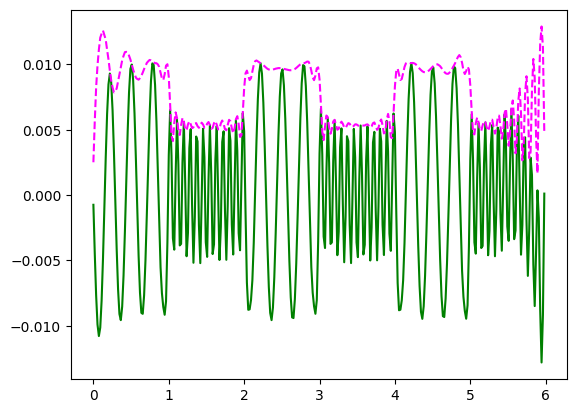

In [20]:
plt.plot(t, analytic_signal[0, :], color = 'green')
plt.plot(t, amplitude_envelope[0, :], linestyle="dashed", color = 'magenta')
plt.show()

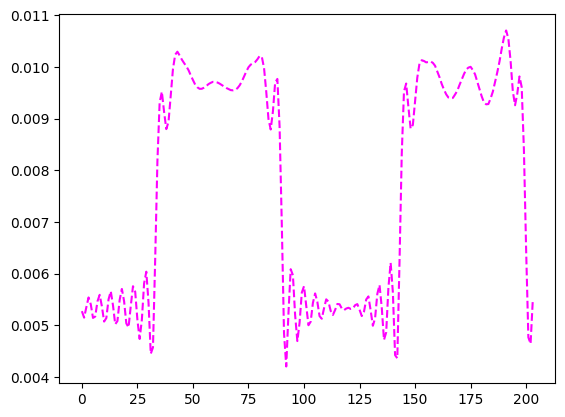

In [158]:
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [159]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.00532706 0.00778872 0.00263901 0.01404205 0.00290071 0.00648686
  0.00074324 0.00022312 0.00411435 0.00078241]
 [0.00964293 0.01230324 0.00299206 0.02377518 0.00481872 0.0089953
  0.00117355 0.00036835 0.00654085 0.00122974]]
(205,)


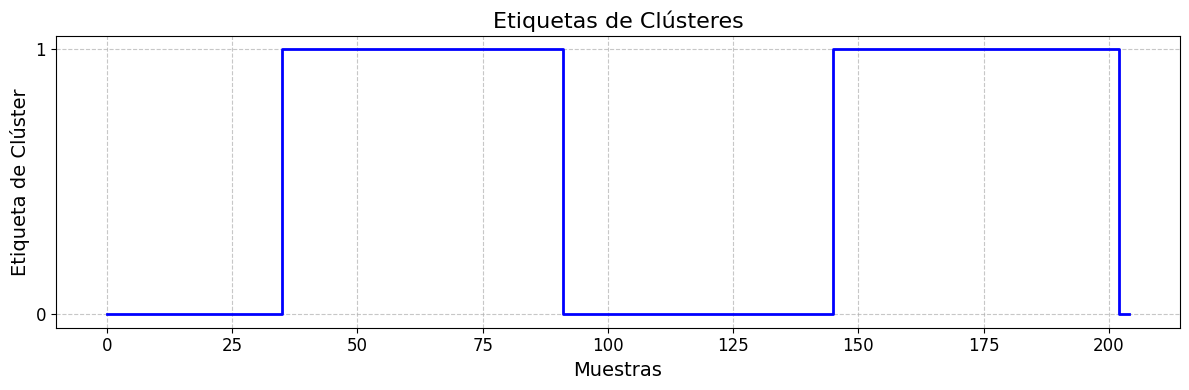

In [160]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Cuántico con estado.

In [176]:
# Number of qubits (size of quantum reservoir)
num_qubits = 5
# Depth of the reservoir circuit
num_layers = 1  

# Create a quantum device (simulator)
dev = qml.device("default.qubit", wires=num_qubits)

In [177]:
# Definimos el Quantum Reservoir  
def quantum_reservoir(reservoir_weights):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            # Entrelazamiento con el siguiente qubit (circular)  
            control_qubit = i 
            target_qubit = (i + 1) % num_qubits  
            qml.CNOT(wires=[control_qubit, target_qubit])

In [178]:
# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights)
    
    # Devolvemos el estado cuántico completo (amplitudes y fases)
    return qml.state()

In [179]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec = secuencia.reshape(1, len(secuencia))
input_series = sec
time_steps = input_series.shape[1]

# Run QESN
outputs = []
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_state = quantum_echo_state_network(input_series[0, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    # Convertimos el estado cuántico en características utilizables
    real_part = np.real(q_state)  # Parte real de las amplitudes
    imag_part = np.imag(q_state)  # Parte imaginaria
    magnitudes = np.abs(q_state)  # Módulo de las amplitudes


    final_output = magnitudes # usamos el módulo como salida final del algoritmo.

    # Almacenamos el resultado en la lista.
    outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {final_output}")

# Convertimos outputs a numpy array.
outputs = np.array(outputs)

#df = pd.DataFrame(outputs)
#df = df.to_csv("QSimple_states.csv", index=False)

Step 0: [0.03524128 0.03497476 0.10361453 0.19164343 0.03252427 0.29158787
 0.15408083 0.21432046 0.26742096 0.18863433 0.32809837 0.07010574
 0.2320472  0.06255569 0.07333971 0.0784282  0.21721197 0.03009363
 0.00988138 0.05190429 0.26596194 0.05306226 0.23411337 0.17441112
 0.171485   0.28733376 0.0447496  0.33294796 0.1080374  0.01594649
 0.08702029 0.22668374]
Step 1: [0.04033609 0.04279003 0.09827496 0.17801259 0.07349743 0.28854888
 0.13852353 0.15849833 0.19705257 0.17599815 0.32244946 0.10211601
 0.20866107 0.06033979 0.07875413 0.07429045 0.21533047 0.04265999
 0.02095494 0.04500773 0.31097401 0.08854193 0.23660348 0.16166209
 0.1576504  0.29029667 0.08598299 0.38922474 0.10816063 0.0383319
 0.08268472 0.2319114 ]
Step 2: [0.03888213 0.04568116 0.09851175 0.1762075  0.07072782 0.29196614
 0.13924713 0.16115475 0.19952481 0.1769469  0.32430967 0.10370747
 0.20610731 0.06010157 0.08187635 0.07365622 0.21437573 0.04278331
 0.02206922 0.04569632 0.30924458 0.09054036 0.23663208 0.

In [180]:
print(outputs.shape)

(330, 32)


In [192]:
#df = pd.read_csv("QSimple_states.csv")
#outputs = df.to_numpy()  # O también df.values

In [193]:
outputs = outputs.T

(32, 330)


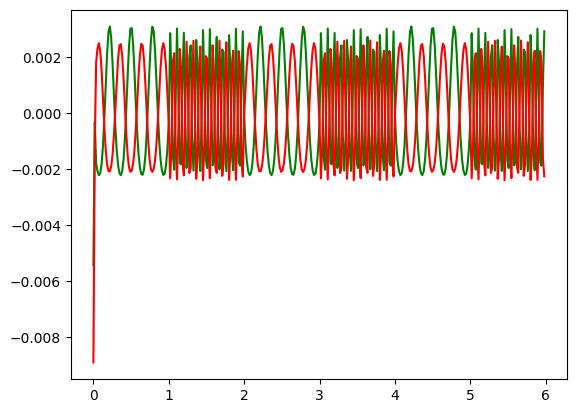

In [194]:
RS_cuantico2 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico2.shape)

plt.plot(t, RS_cuantico2[0, :], color = 'green')
plt.plot(t, RS_cuantico2[1, :], color = 'red')
plt.show()

In [195]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 1  # Frecuencia baja del filtro
highcut = 12  # Frecuencia alta del filtro

In [196]:
RS_cuantico2.shape

(32, 330)

In [209]:
x_filtered = bandpass_filter(RS_cuantico2, lowcut, highcut, fs)
analytic_signal = hilbert(x_filtered)
amplitude_envelope_cuant2 = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope_cuant2.shape)

(32, 330)
(32, 330)


C:\Users\Yolanda\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Yolanda\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


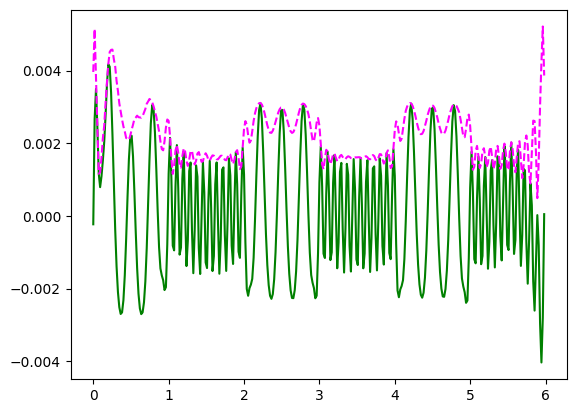

In [210]:
plt.plot(t, analytic_signal[0, :], color = 'green')
plt.plot(t, amplitude_envelope_cuant2[0, :], linestyle="dashed", color = 'magenta')
plt.show()

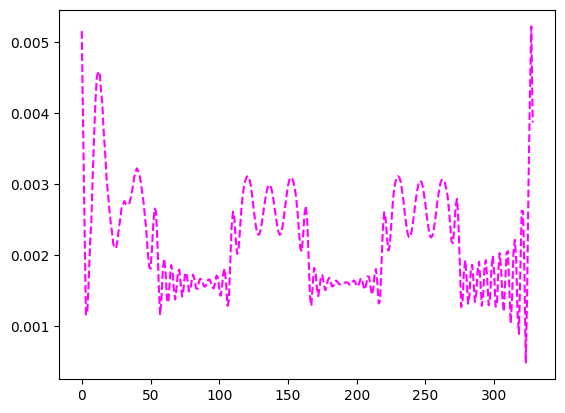

In [211]:
input_sequence_cuant2 = amplitude_envelope_cuant2
plt.plot(input_sequence_cuant2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [212]:
input_sequence_cuant2.T.shape

(330, 32)

In [213]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant2.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.00167045 0.00160167 0.00120946 0.00420525 0.00177406 0.00502068
  0.00078427 0.00247561 0.00365055 0.00144053 0.01152623 0.00619457
  0.00818595 0.00066461 0.00031237 0.00175644 0.00081608 0.00188796
  0.00293376 0.00228239 0.01215699 0.00757294 0.00017829 0.00141116
  0.00103018 0.00307503 0.00181038 0.0140668  0.00013881 0.01120978
  0.00272996 0.00111817]
 [0.00268188 0.00290889 0.00203686 0.00729291 0.00401206 0.00794164
  0.00178769 0.00557734 0.00771942 0.00251372 0.01828453 0.01081527
  0.01395303 0.00117314 0.00086132 0.00305255 0.00138227 0.00323782
  0.0056216  0.0037148  0.02105265 0.01320501 0.00041807 0.0024704
  0.00191036 0.00477945 0.00411888 0.02445132 0.00022651 0.01856223
  0.00449692 0.00185188]]
(330,)


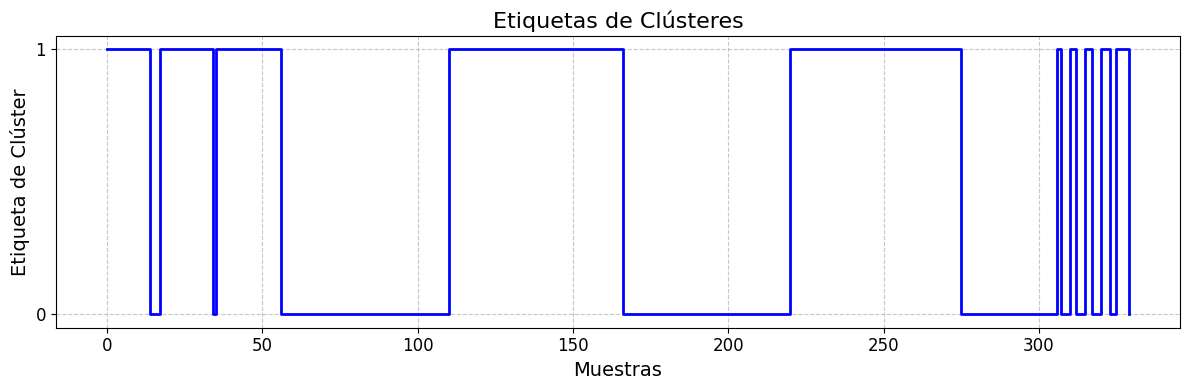

In [214]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant2.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Señal senoidal más compleja(implementación clásica).

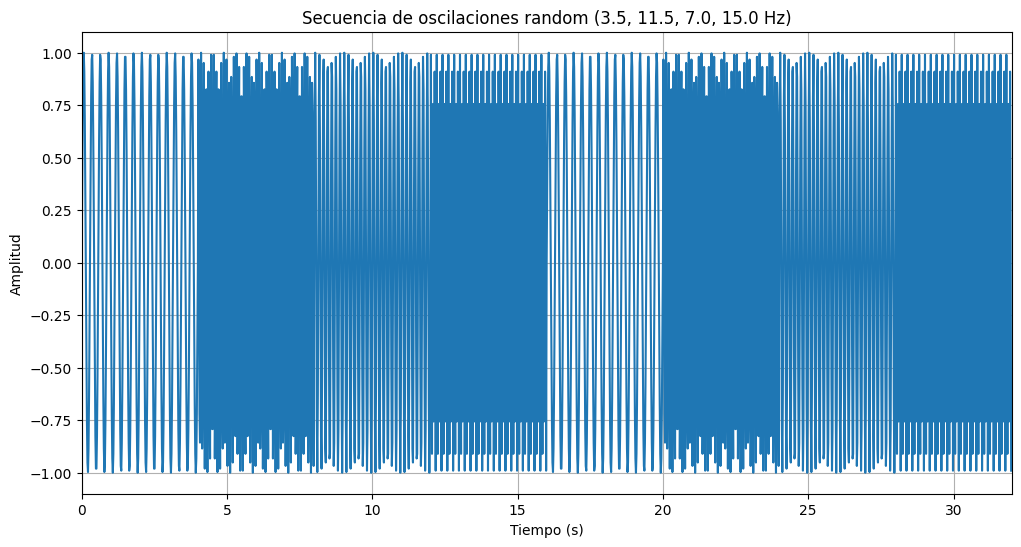

In [215]:
# Parámetros  
fs = 55            # Frecuencia de muestreo en Hz  
t_total = 32        # Duración total en segundos  
frecuencias = [3.5, 11.5, 7.0, 15.0]  # Cuatro frecuencias en Hz  
duracion_segmento = 4  # Duración de cada segmento en segundos  
num_repeticiones = 2 # 3 repeticiones = 12 segundos 

# Inicializamos la secuencia final como una lista  
secuencia2 = []  
amplitud = 1  

# Bucle externo para repetir el ciclo completo  
for i in range(num_repeticiones):  
    # Bucle interno para iterar sobre cada frecuencia en el ciclo  
    for frecuencia_idx in range(len(frecuencias)):  
        # Calcular el tiempo para el segmento actual  
        tiempo_segmento = np.arange(0, duracion_segmento, 1/fs)  
        
        # Calcular la frecuencia basada en el índice del segmento  
        frecuencia_actual = frecuencias[frecuencia_idx]  

        # Generar la oscilación según la frecuencia correspondiente  
        oscilacion = amplitud * np.sin(2 * np.pi * frecuencia_actual * tiempo_segmento)  

        secuencia2.extend(oscilacion)  # Añadir el segmento a la secuencia  

# Convertir la secuencia a un arreglo numpy para facilitar su manejo  
secuencia2 = np.array(secuencia2) 

# Crear el tiempo correspondiente a la secuencia  
t2 = np.arange(0, len(secuencia2)/fs , 1/fs)

# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t2, secuencia2)  
plt.title('Secuencia de oscilaciones random (3.5, 11.5, 7.0, 15.0 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

In [216]:
# Parámetros
num_input_channels = 1      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 20   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = t2.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

sec2 = secuencia2.reshape(1, len(secuencia2))

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ sec2[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS2 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS2.shape)

# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 15  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS2, lowcut, highcut, fs)

analytic_signal = hilbert(x_filtered)
amplitude_envelope2 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(x_filtered.shape)
print(amplitude_envelope2.shape)

(20, 1761)
(20, 1761)
(20, 1761)
(20, 1761)


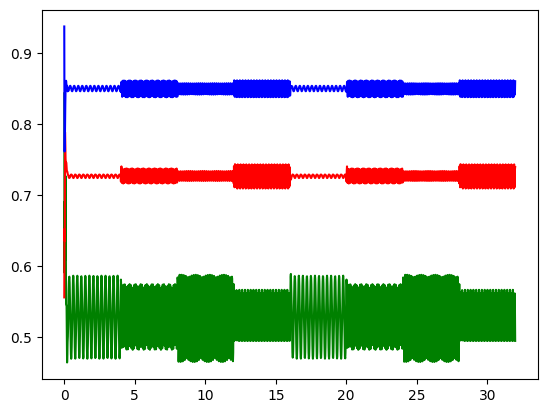

In [217]:
plt.plot(t2, reservoir_states[0, 1:], color = 'green')
plt.plot(t2, reservoir_states[1, 1:], color = 'red')
plt.plot(t2, reservoir_states[2, 1:], color = 'blue')
plt.show()

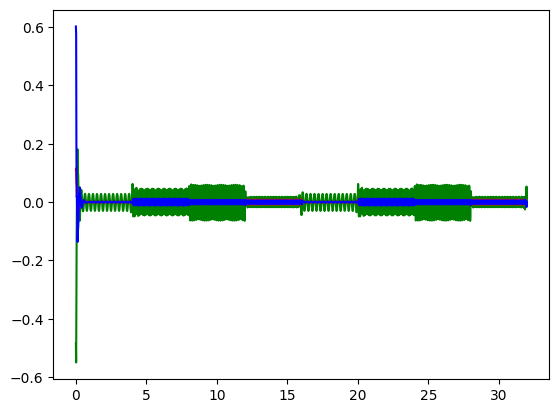

In [218]:
plt.plot(t2, x_filtered[0, 1:], color = 'green')
plt.plot(t2, x_filtered[1, 1:], color = 'red')
plt.plot(t2, x_filtered[2, 1:], color = 'blue')
plt.show()

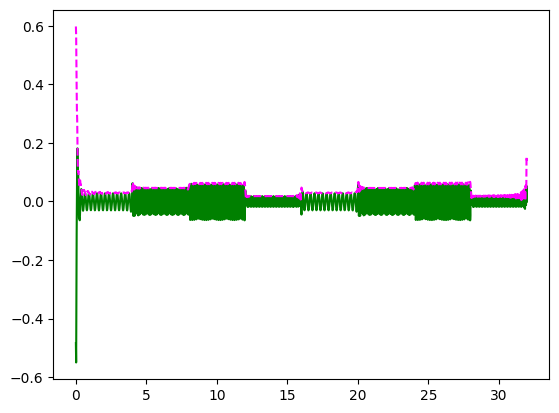

In [219]:
plt.plot(t2, x_filtered[0, 1:], color = 'green')
plt.plot(t2, amplitude_envelope2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

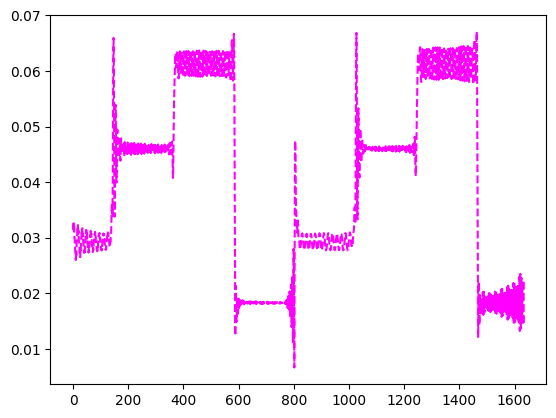

In [220]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(75, amplitude_envelope2.shape[1])
input_sequence2 = amplitude_envelope2[:, stable_start:-50]
plt.plot(input_sequence2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [221]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence2.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)
print(input_sequence2.shape)

Centroides de los clústeres:
[[0.02960043 0.00133064 0.00231353 0.02004449 0.01543257 0.00877704
  0.02469808 0.00525089 0.01203992 0.02168757 0.03338405 0.01547437
  0.00840527 0.00897506 0.00304142 0.01613626 0.06252331 0.04370198
  0.01299446 0.01854971]
 [0.046008   0.01044546 0.01175127 0.02635502 0.04302296 0.02389232
  0.03341939 0.00299748 0.08651855 0.07900677 0.05585452 0.02985975
  0.03015149 0.01663786 0.02764294 0.04169425 0.1264804  0.07095057
  0.01155401 0.03000588]
 [0.06117131 0.00709792 0.00799324 0.03726385 0.03679011 0.02124686
  0.04594104 0.00664546 0.0516591  0.04261502 0.05461319 0.03233231
  0.02218271 0.00777274 0.01808626 0.03727661 0.12857898 0.07184674
  0.02125499 0.03519945]
 [0.01831797 0.00854439 0.00620787 0.01335371 0.01958957 0.00709364
  0.01719703 0.00473968 0.03644323 0.04853576 0.02388543 0.00912693
  0.01328477 0.01253403 0.00480704 0.01473684 0.04628489 0.02262876
  0.00519421 0.0116363 ]]
(1636,)
(20, 1636)


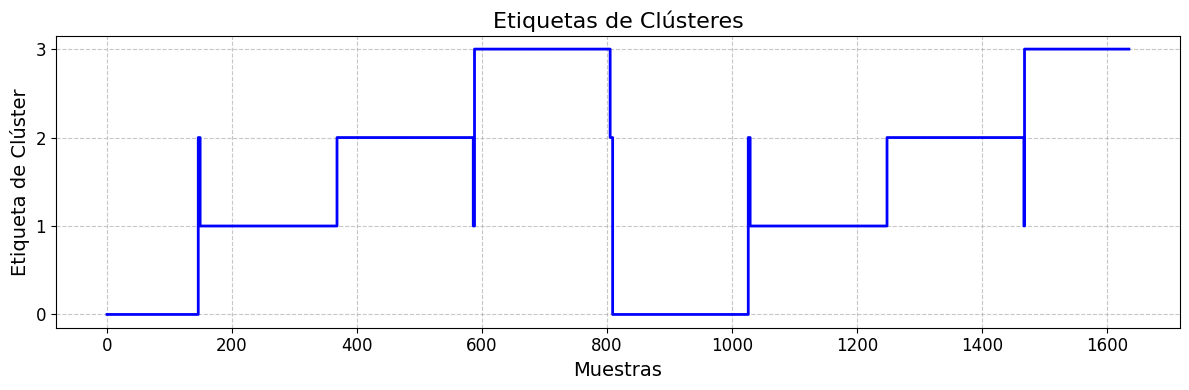

In [222]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence2.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

In [223]:
secuencia2.shape

(1760,)

In [224]:
stable_start = min(75, len(secuencia2))
secuencia22 = secuencia2[stable_start:-50]
secuencia22.shape

(1635,)

In [225]:
stable_start = min(75, len(t2))
t22 = t2[stable_start:-50]
t22.shape

(1635,)

In [226]:
idx.shape

(1636,)

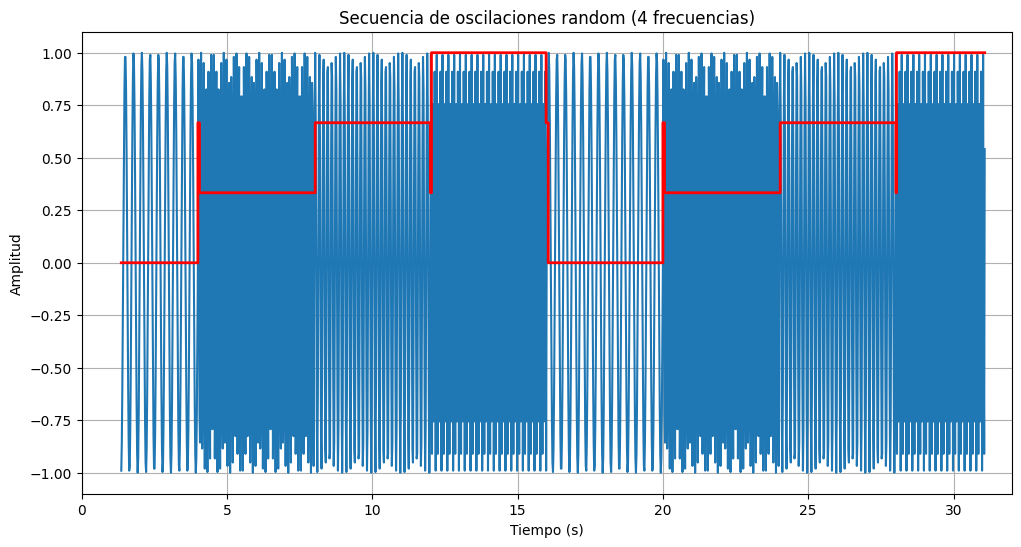

In [227]:
# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t22, secuencia22)
plt.step(t22, idx[1:]/3, where='post', color='red', linewidth=2) 
plt.title('Secuencia de oscilaciones random (4 frecuencias)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Señal senoidal más compleja(implementación cuántica).

### 20 qubits.

In [47]:
# Number of qubits (size of quantum reservoir)
num_qubits = 20
# Depth of the reservoir circuit
num_layers = 1  

# Create a quantum device (simulator)
dev = qml.device("default.qubit", wires=num_qubits)

In [48]:
# Definir el Quantum Reservoir  
def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            
    # Aplicar entrelazamiento entre los qubits seleccionados.(conectividad limitada)
    if connectivity == 'ring':
        for j in range(num_qubits - 1):
            qml.CNOT(wires=[j, j+1])  # Apply entanglement between adjacent qubits
                     
                
    if connectivity == 'star':
    # Entangling the first qubit (central node) with all other qubits
        central_qubit = 0  # We use qubit 0 as the central node
        for j in range(1, num_qubits):
             qml.CNOT(wires=[central_qubit, j])
 
    if connectivity == 'random':
            # Crear pares de qubits aleatorios
              qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]
              random.shuffle(qubit_pairs)
            # Entrelazar aleatoriamente
              for j, k in qubit_pairs[:num_qubits // 2]:
                  qml.CNOT(wires=[j, k])
 
    elif connectivity == 'full':
            # Full connectivity: entangle all pairs of qubits
              for j in range(num_qubits):
                 for k in range(j + 1, num_qubits):  # Loop over all pairs of qubits
                    qml.CNOT(wires=[j, k])  # Apply entanglement between qubit j and k        

In [49]:
# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    # Measure expectation values (output features)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [50]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec2 = secuencia2.reshape(1, len(secuencia2))
input_series = sec2
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps))
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[:, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output).squeeze()
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {outputs[:, t0]}")

Step 0: [-0.59925689 -0.18971484  0.21811214  0.6615426   0.69440747 -0.33226699
  0.37386295 -0.71776698 -0.48770536  0.49250797 -0.71722767 -0.71855856
 -0.64261142 -0.64192026  0.71278251 -0.17404693  0.15490492 -0.37241191
 -0.22484115  0.40677679]
Step 1: [-0.72701036  0.01252062 -0.0039785   0.23233721  0.64355029 -0.72629273
  0.57517701  0.28724196 -0.00508432 -0.00765097 -0.50861221 -0.21873531
  0.18724861  0.51325858 -0.20197914  0.01330104  0.03361237 -0.36325059
  0.09082608 -0.12546739]
Step 2: [-0.73616971 -0.22950178  0.18630277  0.626426    0.72383992 -0.54504343
  0.11475776 -0.16721375 -0.46316066  0.44305951 -0.69180508 -0.62936419
 -0.65196394 -0.75832025  0.59872533 -0.16388153  0.18358657 -0.42665339
 -0.3650375   0.43312859]
Step 3: [-7.32717123e-01  9.89610784e-02 -3.42380699e-02  2.45370484e-01
  6.30632877e-01 -7.15343825e-01  7.32823996e-01 -6.39536204e-01
  1.51667123e-02 -1.27114386e-02 -4.99450034e-01 -2.90090971e-01
  2.48178890e-01  5.00272230e-01  3.38


KeyboardInterrupt



In [ ]:
# Extracción de la envolvente superior usando Hilbert transform
RS_cuantico_2 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_2.shape)

plt.plot(t2, RS_cuantico_2[0, :], color = 'green')
plt.plot(t2, RS_cuantico_2[1, :], color = 'red')
plt.plot(t2, RS_cuantico_2[2, :], color = 'blue')
plt.show()

In [ ]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [ ]:
# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 15  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS_cuantico_2, lowcut, highcut, fs)

In [ ]:
analytic_signal = hilbert(x_filtered)
amplitude_envelope = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope.shape)

In [ ]:
stable_start = min(90, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
print(input_sequence.shape)
plt.plot(input_sequence[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
np.save("data_20_qubit.npy", input_sequence)

In [ ]:
input_sequence_20 = np.load("data_20_qubit.npy")

In [ ]:
fs = 55
lowcut = 3.5
highcut = 15

input_sequence_filtered = bandpass_filter(input_sequence_20, lowcut, highcut, fs)

plt.plot(input_sequence_filtered[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
window_size = 5  # Define el tamaño de la ventana  
input_sequence_mean = np.array([pd.Series(input_sequence_20.T[:, i]).rolling(window=window_size, min_periods=1).mean() for i in range(input_sequence_20.shape[0])]).T

In [ ]:
plt.plot(input_sequence_mean[:,0], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
input_sequence_mean.shape

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
labels = clustering.fit_predict(input_sequence_mean)

plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_mean.shape[0]), labels, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(4))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors   
  
k = 50  # o el valor que hayas definido para min_samples  
nbrs = NearestNeighbors(n_neighbors=k).fit(input_sequence_mean)  
distances, indices = nbrs.kneighbors(input_sequence_mean)  

# Tomar la distancia al k-ésimo vecino  
k_distances = distances[:, -1]  

In [ ]:
k_distances_sorted = np.sort(k_distances)  
plt.plot(k_distances_sorted)  
plt.xlabel('Puntos')  
plt.ylabel(f'Distancia al {k}-ésimo vecino más cercano')  
plt.title('Gráfico de k-Distancias')  
plt.grid()  
plt.show()  

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.06, min_samples=50).fit(input_sequence_mean)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [ ]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_mean.shape[0]), labels, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(7))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

In [ ]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_mean)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

In [ ]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_mean.shape[0]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

### 10 qubits.

In [ ]:
# Number of qubits (size of quantum reservoir)
num_qubits = 10
# Depth of the reservoir circuit
num_layers = 1  

# Create a quantum device (simulator)
dev2 = qml.device("default.qubit", wires=num_qubits)

In [ ]:
# Definir el Quantum Reservoir  
def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            
    # Aplicar entrelazamiento entre los qubits seleccionados.(conectividad limitada)
    if connectivity == 'ring':
        for j in range(num_qubits - 1):
            qml.CNOT(wires=[j, j+1])  # Apply entanglement between adjacent qubits
                     
                
    if connectivity == 'star':
    # Entangling the first qubit (central node) with all other qubits
        central_qubit = 0  # We use qubit 0 as the central node
        for j in range(1, num_qubits):
             qml.CNOT(wires=[central_qubit, j])
 
    if connectivity == 'random':
            # Crear pares de qubits aleatorios
              qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]
              random.shuffle(qubit_pairs)
            # Entrelazar aleatoriamente
              for j, k in qubit_pairs[:num_qubits // 2]:
                  qml.CNOT(wires=[j, k])
 
    elif connectivity == 'full':
            # Full connectivity: entangle all pairs of qubits
              for j in range(num_qubits):
                 for k in range(j + 1, num_qubits):  # Loop over all pairs of qubits
                    qml.CNOT(wires=[j, k])  # Apply entanglement between qubit j and k

In [ ]:
# Define Quantum Node
@qml.qnode(dev2)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    # Measure expectation values (output features)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [ ]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec2 = secuencia2.reshape(1, len(secuencia2))
input_series = sec2
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps))
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[:, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output).squeeze()
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {outputs[:, t0]}")

In [ ]:
# Extracción de la envolvente superior usando Hilbert transform
RS_cuantico_3 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_3.shape)

plt.plot(t2, RS_cuantico_3[0, :], color = 'green')
plt.plot(t2, RS_cuantico_3[1, :], color = 'red')
plt.plot(t2, RS_cuantico_3[2, :], color = 'blue')
plt.show()

In [ ]:
# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 15  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS_cuantico_3, lowcut, highcut, fs)

In [ ]:
analytic_signal = hilbert(x_filtered)
amplitude_envelope2 = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope2.shape)

In [ ]:
stable_start = min(90, amplitude_envelope2.shape[1])
input_sequence2 = amplitude_envelope2[:, stable_start:-50]
print(input_sequence2.shape)
plt.plot(input_sequence2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence2.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

In [ ]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence2.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

### Implementación cuántica con estados de los qubits.

In [338]:
# Number of qubits (size of quantum reservoir)
num_qubits = 3
# Depth of the reservoir circuit
num_layers = 1  

# Create a quantum device (simulator)
dev3 = qml.device("default.qubit", wires=num_qubits)

In [339]:
# Definir el Quantum Reservoir  
def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            
    # Aplicar entrelazamiento entre los qubits seleccionados.(conectividad limitada)
    if connectivity == 'ring':
        for j in range(num_qubits - 1):
            qml.CNOT(wires=[j, j+1])  # Apply entanglement between adjacent qubits
                     
                
    if connectivity == 'star':
    # Entangling the first qubit (central node) with all other qubits
        central_qubit = 0  # We use qubit 0 as the central node
        for j in range(1, num_qubits):
             qml.CNOT(wires=[central_qubit, j])
 
    if connectivity == 'random':
            # Crear pares de qubits aleatorios
              qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]
              random.shuffle(qubit_pairs)
            # Entrelazar aleatoriamente
              for j, k in qubit_pairs[:num_qubits // 2]:
                  qml.CNOT(wires=[j, k])
 
    elif connectivity == 'full':
            # Full connectivity: entangle all pairs of qubits
              for j in range(num_qubits):
                 for k in range(j + 1, num_qubits):  # Loop over all pairs of qubits
                    qml.CNOT(wires=[j, k])  # Apply entanglement between qubit j and k

In [340]:
# Define Quantum Node
@qml.qnode(dev3)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    # Devolvemos el estado cuántico completo (amplitudes y fases)
    return qml.probs(wires=range(num_qubits))

In [341]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec2 = secuencia2.reshape(1, len(secuencia2))
input_series2 = sec2
time_steps = input_series2.shape[1]

# Run QESN
outputs = []
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_prob = quantum_echo_state_network(input_series2[0, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    # Convertimos el estado cuántico en características utilizables
    #real_part = np.real(q_state)  # Parte real de las amplitudes
    #imag_part = np.imag(q_state)  # Parte imaginaria
    #magnitudes = np.abs(q_state)  # Módulo de las amplitudes


    final_output = np.tanh(q_prob) # usamos el módulo como salida final del algoritmo.

    # Almacenamos el resultado en la lista.
    outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {final_output}")

# Convertimos outputs a numpy array.
outputs = np.array(outputs)

Step 0: [0.29678637 0.04069474 0.01125079 0.08435284 0.01417356 0.10612101
 0.36746838 0.05125123]
Step 1: [0.13763356 0.01949035 0.00736611 0.0522955  0.02646191 0.18589108
 0.4603051  0.06992653]
Step 2: [0.18972005 0.02952959 0.01110371 0.07207018 0.02531133 0.16312984
 0.41186352 0.06724339]
Step 3: [0.15627026 0.02514538 0.01052359 0.06583416 0.03007414 0.18626207
 0.42222367 0.07177058]
Step 4: [0.16694276 0.02735623 0.01143694 0.0703232  0.02973121 0.18113773
 0.4121438  0.07103041]
Step 5: [0.16669951 0.02669109 0.01099154 0.06917022 0.02893592 0.18043249
 0.41619976 0.07018384]
Step 6: [0.17845746 0.02716364 0.01043953 0.06920174 0.02589082 0.17025815
 0.41981062 0.06729522]
Step 7: [0.19079991 0.02690813 0.00939706 0.06734291 0.02224794 0.15835657
 0.4279575  0.06364404]
Step 8: [0.20620072 0.02659045 0.00825714 0.06485795 0.01846304 0.14422729
 0.43643275 0.05940587]
Step 9: [0.22015027 0.02593891 0.00715316 0.06163006 0.01529633 0.13120435
 0.4451485  0.05542678]
Step 10: [

In [342]:
print(outputs.shape)
outputs = outputs.T

(1760, 8)


(8, 1760)


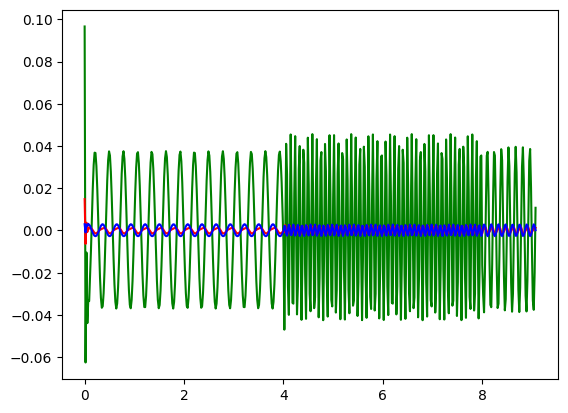

In [343]:
RS_cuant_2 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuant_2.shape)

plt.plot(t2[:500], RS_cuant_2[0, :500], color = 'green')
plt.plot(t2[:500], RS_cuant_2[1, :500], color = 'red')
plt.plot(t2[:500], RS_cuant_2[2, :500], color = 'blue')
plt.show()

In [344]:
# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 15  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered_cuant_2 = bandpass_filter(RS_cuant_2, lowcut, highcut, fs)

In [345]:
analytic_signal = hilbert(x_filtered_cuant_2)
amplitude_envelope_cuant2 = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope_cuant2.shape)

(8, 1760)
(8, 1760)


(8, 1702)


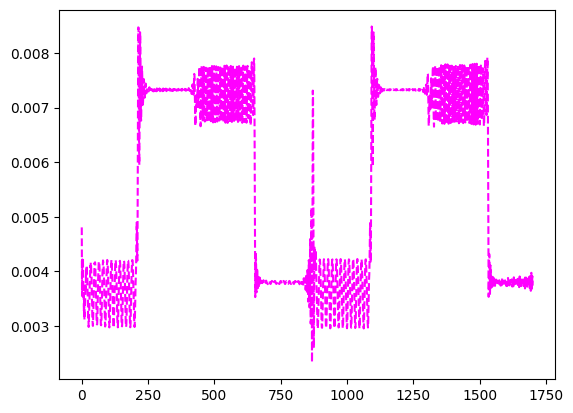

In [352]:
stable_start = min(90, amplitude_envelope_cuant2.shape[0])
input_sequence_cuantico2 = amplitude_envelope_cuant2[:, stable_start:-50]
print(input_sequence_cuantico2.shape)
plt.plot(input_sequence_cuantico2[3, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [347]:
print(input_sequence_cuantico2.shape)

(8, 1702)


In [348]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuantico2.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.01873453 0.00068097 0.00142137 0.00365011 0.00466366 0.0175604
  0.01165976 0.00533473]
 [0.04398492 0.00201222 0.00271182 0.00734774 0.00947868 0.03541911
  0.0227719  0.01213109]
 [0.02542706 0.00134177 0.00130597 0.00383997 0.00489614 0.0185284
  0.01132692 0.00662291]
 [0.03917876 0.00150741 0.00279218 0.0072274  0.00930413 0.03492138
  0.02296985 0.01111846]]
(1702,)


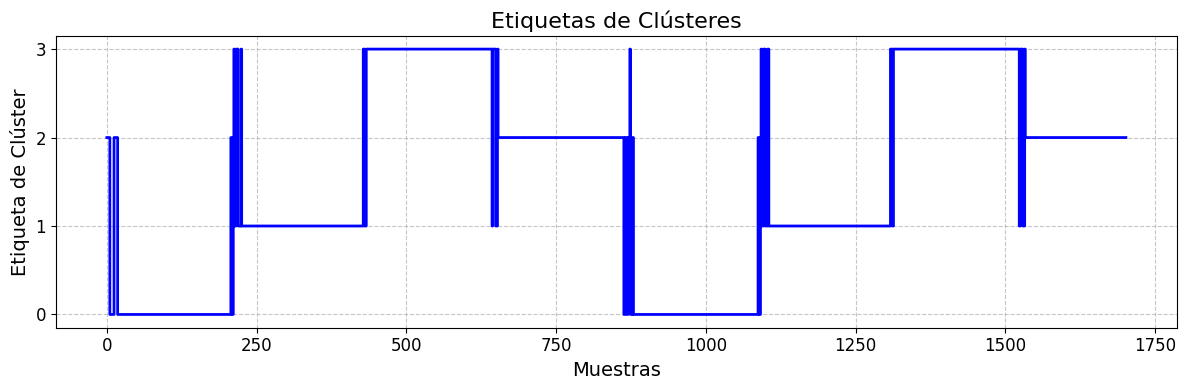

In [349]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuantico2.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

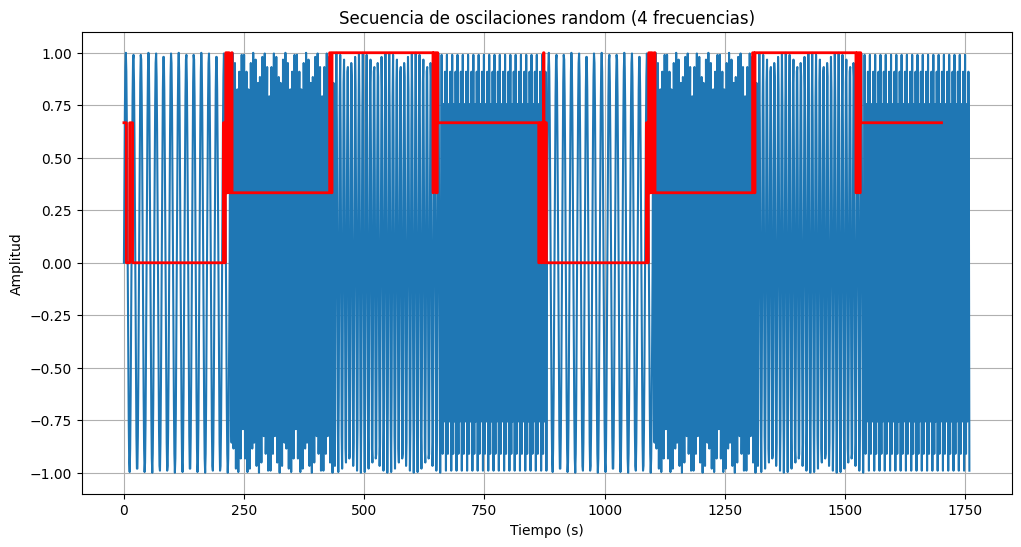

In [350]:
# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(secuencia2)
plt.step(range(input_sequence_cuantico2.shape[1]), idx/3, where='post', color='red', linewidth=2) 
plt.title('Secuencia de oscilaciones random (4 frecuencias)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
#plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## EEG reales.

In [ ]:
# Carga de datos.
eeg_young = np.load("./data/data/dataset_Younger.npy")
eeg_old = np.load("./data/data/dataset_Older.npy")

In [ ]:
eeg_young.shape

In [ ]:
# Cogemos la señal de un canal de un sujeto joven.
muestra = eeg_young[0,:,:]

plt.plot(range(muestra.shape[0]), muestra[:,0], color = 'blue')
plt.show()

In [ ]:
muestra2 = muestra[:,0:10]
muestra2.shape

In [ ]:
# Implementación reservoir clásico con esta muestra.

# Parámetros
num_input_channels = 10      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 30   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = muestra2.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ muestra2[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS3 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS3.shape)
analytic_signal = hilbert(RS3)
amplitude_envelope3 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS3.shape)
print(amplitude_envelope3.shape)

In [ ]:
plt.plot(range(muestra.shape[0]), RS3[0, 1:], color = 'green')
plt.plot(range(muestra.shape[0]), RS3[1, 1:], color = 'red')
plt.plot(range(muestra.shape[0]), RS3[2, 1:], color = 'blue')
plt.show()

In [ ]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(100, amplitude_envelope3.shape[1])
input_sequence3 = amplitude_envelope3[:, stable_start:-50]
plt.plot(input_sequence3[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence3.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

In [ ]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence3.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([0,400])
plt.tight_layout() 
plt.show()

In [ ]:
# Encontrar el número de estados del cerebro

silhouette_scores = []  
clusters_range = range(2, 5)  # Clústeres de 2 a 4  
labels_clusters = []

for num_clusters in clusters_range:  
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence3.T)  
    labels = kmeans.labels_  
    labels_clusters.append(labels)
    silhouette_avg = silhouette_score(input_sequence3.T, labels)  
    silhouette_scores.append(silhouette_avg)  
    print(f'Número de clústeres: {num_clusters}, Coeficiente Silhouette: {silhouette_avg:.4f}')  

# Graficar los resultados  
plt.figure(figsize=(8, 5))  
plt.plot(clusters_range, silhouette_scores, marker='o')  
plt.title('Coeficiente Silhouette para diferentes números de clústeres')  
plt.xlabel('Número de clústeres')  
plt.ylabel('Coeficiente Silhouette')  
plt.xticks(clusters_range)  
plt.grid()  
plt.show() 

## EEG simulados.

### Versión clásica.

In [ ]:
synthetic_data = np.load('data/data/synthetic_data_auto.npy')
synthetic_data.shape

#### Sujeto joven.

In [ ]:
muestra_synt = synthetic_data[0,:,:]
muestra_synt2 = synthetic_data[1,:,:]

In [ ]:
# Reescalar la señal
def reescaled(input_signal, min_val, max_val): 
   # Calcular el rango original  
   original_min = np.min(input_signal)  
   original_max = np.max(input_signal)  

   # Reescalar la señal  
   scaled_signal = (muestra_synt - original_min) / (original_max - original_min) * (max_val - min_val) + min_val

   return scaled_signal

In [ ]:
scaled_signal = reescaled(muestra_synt, min_val = -1, max_val = 1)

In [ ]:
plt.plot(range(scaled_signal.shape[0]), scaled_signal[:,0], color = 'blue')
plt.show()

In [ ]:
# Implementación reservoir clásico con EEG simulados.

# Parámetros
num_input_channels = 10      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 100   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = scaled_signal.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ scaled_signal[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS4 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS4.shape)

# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 512  # Frecuencia de muestreo
lowcut = 0.5  # Frecuencia baja del filtro
highcut = 100  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS4, lowcut, highcut, fs)

analytic_signal = hilbert(x_filtered)
amplitude_envelope4 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS4.shape)
print(amplitude_envelope4.shape)

In [ ]:
plt.plot(range(muestra_synt.shape[0]), RS4[0, 1:], color = 'green')
plt.plot(range(muestra_synt.shape[0]), RS4[1, 1:], color = 'red')
plt.plot(range(muestra_synt.shape[0]), RS4[2, 1:], color = 'blue')
plt.show()

In [ ]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(200, amplitude_envelope4.shape[1])
input_sequence4 = amplitude_envelope4[:, stable_start:-50]
plt.plot(input_sequence4[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence4.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

In [ ]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence4.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([0,200])
plt.tight_layout() 
plt.show()

#### Sujeto mayor.

In [ ]:
muestra_synt_adult = synthetic_data[30,:,:]

In [ ]:
plt.plot(range(muestra_synt_adult.shape[0]), muestra_synt_adult[:,0], color = 'blue')
plt.show()

In [ ]:
scaled_signal2 = reescaled(muestra_synt_adult, -1, 1)

In [ ]:
plt.plot(range(scaled_signal2.shape[0]), scaled_signal2[:,0], color = 'blue')
plt.show()

In [ ]:
# Implementación reservoir clásico con EEG simulados.

# Parámetros
num_input_channels = 10      # Dimensionalidad de entrada(canales)
num_reservoir_neurons = 100   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = scaled_signal.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ scaled_signal2[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS5 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS5.shape)

# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 512  # Frecuencia de muestreo
lowcut = 0.5  # Frecuencia baja del filtro
highcut = 100  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS5, lowcut, highcut, fs)

analytic_signal = hilbert(x_filtered)
amplitude_envelope5= np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS5.shape)
print(amplitude_envelope5.shape)

In [ ]:
plt.plot(range(muestra_synt_adult.shape[0]), RS5[0, 1:], color = 'green')
plt.plot(range(muestra_synt_adult.shape[0]), RS5[1, 1:], color = 'red')
plt.plot(range(muestra_synt_adult.shape[0]), RS5[2, 1:], color = 'blue')
plt.show()

In [ ]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(200, amplitude_envelope5.shape[1])
input_sequence5 = amplitude_envelope5[:, stable_start:-50]
plt.plot(input_sequence5[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence5.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

In [ ]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence5.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([0,200])
plt.tight_layout() 
plt.show()

### Versión cuántica.

In [ ]:
# Hiperparámetros  
num_qubits = 10  # Ajustamos 10 qubit para cada canal 
dev = qml.device("default.qubit", wires=num_qubits)    
num_channels = 10 # tenemos 10 canales 


def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):  
         for j in range(num_qubits):  
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)  

    # Aplicar entrelazamiento entre los qubits seleccionados.(conectividad limitada)  
    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  # Apply entanglement between adjacent qubits  


    if connectivity == 'star':  
    # Entangling the first qubit (central node) with all other qubits  
        central_qubit = 0  # We use qubit 0 as the central node  
        for j in range(1, num_qubits):  
             qml.CNOT(wires=[central_qubit, j])  

    if connectivity == 'random':  
            # Crear pares de qubits aleatorios  
              qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
              random.shuffle(qubit_pairs)  
            # Entrelazar aleatoriamente  
              for j, k in qubit_pairs[:num_qubits // 2]:  
                  qml.CNOT(wires=[j, k])  

    elif connectivity == 'full':  
            # Full connectivity: entangle all pairs of qubits  
              for j in range(num_qubits):  
                 for k in range(j + 1, num_qubits):  # Loop over all pairs of qubits  
                    qml.CNOT(wires=[j, k])  # Apply entanglement between qubit j and k 


# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    # Measure expectation values (output features)
    return np.array([[qml.expval(qml.PauliZ(i))] for i in range(num_qubits)])

In [ ]:
scaled_signal.shape

In [ ]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

input_series = scaled_signal
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps, num_channels))
prev_output = np.zeros(num_qubits)  # Initial output


for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[t0, :], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}, Channel {i+1}: {outputs[:, t0]}")

## Otra implementación cuántica.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.quantum_info import random_unitary
from qiskit_aer import AerSimulator

from quantumreservoirpy.plot import feature_plotter
from quantumreservoirpy.reservoirs import Static

In [ ]:
secuencia.shape

In [ ]:
num_qubits = 5
operator = random_unitary(2 ** num_qubits, seed=417)
backend = AerSimulator()

In [ ]:
class QuantumReservoir(Static):

    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep, reservoirnumber):
        circuit.initialize(int(timestep % 2), 1)
        circuit.append(operator, circuit.qubits)
        circuit.measure([0, 1])

In [ ]:
quantum_res = QuantumReservoir(n_qubits=num_qubits, backend=backend)
quantum_data = quantum_res.run(timeseries=secuencia, shots=10000)

In [ ]:
# Extracción de la envolvente superior usando Hilbert transform
RS_quant = quantum_data - np.mean(quantum_data,axis=1, keepdims=True)
print(RS_quant.shape)

plt.plot(t, RS_quant[:, 0], color = 'green')
plt.plot(t, RS_quant[:, 1], color = 'red')
plt.show()

In [ ]:
analytic_signal = hilbert(RS_quant)
amplitude_envelope = np.abs(analytic_signal)

# Eliminamos los primeros 75 puntos para estabilizar el reservorio
stable_start = min(75, analytic_signal.shape[0])
input_sequence = analytic_signal[stable_start:-50, :]
plt.plot(input_sequence[1:, 0], linestyle="dashed", color = 'magenta')
plt.show()

In [ ]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

In [ ]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[0]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()